<a href="https://colab.research.google.com/github/trishnak99/ai_colab_2/blob/master/hw2_problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of MNIST digits with dense layers

## Loading the image data

In [0]:
from keras.datasets import mnist

(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

Using TensorFlow backend.


## Preparing the image data

In [0]:
train_images = train_images_original.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

## Preparing the labels

We need to categorically encode the labels.

In [0]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels_original)
test_labels = to_categorical(test_labels_original)

## Deplaying some of the original and prepared image data and labels

In [0]:
train_images.shape

(60000, 784)

In [0]:
train_images_original.shape

(60000, 28, 28)

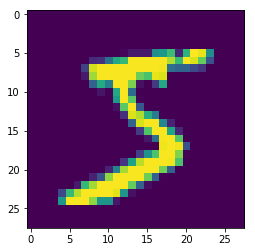

In [0]:
import matplotlib.pyplot as plt
plt.imshow(train_images_original[0])
plt.show()

In [0]:
train_labels.shape

(60000, 10)

In [0]:
train_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [0]:
import numpy as np

In [0]:
np.argmax(train_labels[0])

5

In [0]:
train_labels_original[0]

5

##Handcrafted feature: width

In [0]:
def calcWidth(image):
  imageCopy = np.copy(image)
  for i in range(28):
    [1 if j >= 128 else 0 for j in imageCopy[i]]
    
  ymin = 30
  ymax = -1
  for i in range(28):
    for j in range(28):
      if imageCopy[i][j] == 1 and j < ymin:
        ymin = j
      elif imageCopy[i][j] == 1 and j > ymax:
        ymax = j
  width = (ymax-ymin + 1)/28

  return width

## Handcrafted feature: height

In [0]:
def calcHeight(image):
  imageCopy = np.copy(image)
  for i in range(28):
    [1 if j >= 128 else 0 for j in imageCopy[i]]
  ymin = 30
  ymax = -1
  for i in range(28):
    for j in imageCopy[i]:
      if j == 1 and i < ymin:
        ymin = i
      elif j == 1 and i > ymax:
        ymax = i

  height = (ymax-ymin + 1)/28

  return height

## Handcrafted feature: number of white regions

In [0]:
nextVal = 2

def markWhiteRegion(image, row, col, curVal):
  global nextVal
  if (row >= 28) or (col >= 28):
    return
  if (row < 0) or (col < 0):
    return
  if image[row][col] == 1:
    return
  if image[row][col] > 1:
    return
  
  if image[row][col] == 0:
    image[row][col] = curVal
  
  markWhiteRegion(image, row + 1, col, curVal)
  markWhiteRegion(image, row - 1, col, curVal)
  markWhiteRegion(image, row, col + 1, curVal)
  markWhiteRegion(image, row, col - 1, curVal)

  nextVal = curVal + 1

def countRegions(image):
  global nextVal
  imageCopy = np.copy(image)
  for i in range(28):
    [1 if j >= 128 else 0 for j in imageCopy[i]]
  nextVal = 2

  for i in range(28):
    for j in range(28):
      markWhiteRegion(imageCopy, i, j, nextVal)
  return nextVal-2

##Add Features

In [0]:
whiteReg = np.zeros((60000, 1))
height = np.zeros((60000, 1))
width = np.zeros((60000, 1))
for i in range(60000):
  whiteReg[i] = countRegions(train_images_original[i])
  height[i] = calcHeight(train_images_original[i])
  width[i] = calcWidth(train_images_original[i])

In [0]:
train_images = train_images_original.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

train_images_new = np.column_stack((train_images, whiteReg))
train_images_new2 = np.column_stack((train_images_new, height))
train_images_new3 = np.column_stack((train_images_new2, width))

train_images_new3.shape

(60000, 787)

In [0]:
whiteReg10 = np.zeros((10000, 1))
height10 = np.zeros((10000, 1))
width10 = np.zeros((10000, 1))
for i in range(10000):
  whiteReg10[i] = countRegions(test_images_original[i])
  height10[i] = calcHeight(test_images_original[i])
  width10[i] = calcWidth(test_images_original[i])

In [0]:
test_images = test_images_original.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

test_images_new = np.column_stack((test_images, whiteReg10))
test_images_new2 = np.column_stack((test_images_new, height10))
test_images_new3 = np.column_stack((test_images_new2, width10))

test_images_new3.shape

(10000, 787)

## The network architecture

In [0]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(787,)))
network.add(layers.Dense(10, activation='softmax'))
network.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               403456    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 408,586
Trainable params: 408,586
Non-trainable params: 0
_________________________________________________________________


## The compilation step

In [0]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

## The training step

In [0]:
epochs = 10
history = network.fit(train_images_new3, 
                      train_labels, 
                      epochs=epochs, 
                      batch_size=128, 
                      validation_data=(test_images_new3, test_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.2584 - acc: 0.9256 - val_loss: 0.1271 - val_acc: 0.9631
Epoch 2/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.1035 - acc: 0.9693 - val_loss: 0.0883 - val_acc: 0.9736
Epoch 3/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.0677 - acc: 0.9797 - val_loss: 0.0827 - val_acc: 0.9759
Epoch 4/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.0500 - acc: 0.9847 - val_loss: 0.0722 - val_acc: 0.9777
Epoch 5/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.0367 - acc: 0.9891 - val_loss: 0.0668 - val_acc: 0.9793
Epoch 6/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.0279 - acc: 0.9919 - val_loss: 0.0661 - val_acc: 0.9798
Epoch 7/10
60000/60000 [=========

## Display the training/test loss/accuracy

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs + 1)

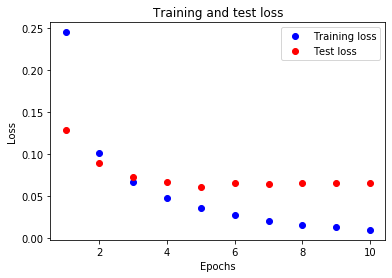

In [0]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

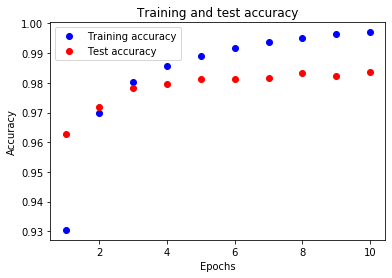

In [0]:
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Overfitting

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That's what you would expect when gradient descent optimization - the quantity you're trying to minimize should be less with every iteration.

But this isn't the case for the training loss and accuracy: they seem to peak at the sixth epoch.

This is an example of overfitting: a model that performs better on the training data isn't necessarily a model that performs better on data it has never seen before. You are overoptimizing on the training data, and you end up learning representations that are specific to the training data and don't generalize to data outside the training set.

## Showing some misclassified digits

In [0]:
predictions = network.predict(test_images)

In [0]:
predictions[0]

array([1.2593197e-10, 2.5504799e-13, 1.6982765e-09, 9.8390474e-06,
       4.8432587e-16, 8.0136751e-11, 4.0219836e-21, 9.9998975e-01,
       8.7284117e-11, 3.3310721e-07], dtype=float32)

In [0]:
np.argmax(predictions[0])

7

In [0]:
test_labels_original[0]

7

In [0]:
predicted_labels = np.argmax(predictions, axis=1) 
predicted_labels = predicted_labels.astype('uint8')

In [0]:
predicted_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [0]:
wrong_indices = [i for i in range(10000) if predicted_labels[i] != test_labels_original[i]]

In [0]:
# The quantity below is equal to the test accuracy reported by the network fit method.
1.0 - len(wrong_indices) / 10000.0

0.9818

In [0]:
# This show the ith misclassified digit. 
i = 4
wrong_index = wrong_indices[i]  

In [0]:
predicted_labels[wrong_index]

7

In [0]:
test_labels_original[wrong_index]

2

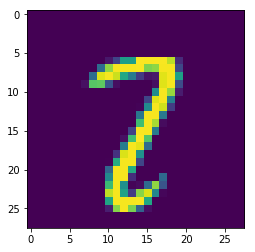

In [0]:
plt.imshow(test_images_original[wrong_index])
plt.show()